# Product Design Mining - as a Product Designer, I want to know users' preferences - specifically paint points - , so that I can improve the product

### False positives are more costly, in that they miss critical negative pain points and feedback by seeing them as positive - this informs metric of F 0.5 on Positive class of sentiment being the focus

### False negatives on Negative class are the focus as they miss out on actual negative feedbacks, informing a metric of F2 on Negative class of sentiment

## Business value: Allows for improving the product and bring in new customers/remedy possible churn of customers from the platform or brand loyalty

# Imports and reading in data

In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import yellowbrick
import tensorflow as tf
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')

# Import the displaCy library
from spacy import displacy

Using TensorFlow backend.
/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from sklearn import metrics
import missingno as msno
import plotly.express as px

In [3]:
plt.style.use('seaborn-talk')
import warnings
warnings.filterwarnings("ignore")

## Reading in data

In [4]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding = "ISO-8859-1")

df.head(20)

tweet_text  \
0   .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1   @jessedee Know about @fludapp ? Awesome iPad/i...   
2   @swonderlin Can not wait for #iPad 2 also. The...   
3   @sxsw I hope this year's festival isn't as cra...   
4   @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5   @teachntech00 New iPad Apps For #SpeechTherapy...   
6                                                 NaN   
7   #SXSW is just starting, #CTIA is around the co...   
8   Beautifully smart and simple idea RT @madebyma...   
9   Counting down the days to #sxsw plus strong Ca...   
10  Excited to meet the @samsungmobileus at #sxsw ...   
11  Find &amp; Start Impromptu Parties at #SXSW Wi...   
12  Foursquare ups the game, just in time for #SXS...   
13  Gotta love this #SXSW Google Calendar featurin...   
14  Great #sxsw ipad app from @madebymany: http://...   
15  haha, awesomely rad iPad app by @madebymany ht...   
16  Holler Gram for iPad on the iTunes App Store -...   
17  I just noticed DST is coming this weekend. How...   
18  Just added my #SXSW flights to @planely. Match...   
19  Must have #SXSW app! RT @malbonster: Lovely re...   

    emotion_in_tweet_is_directed_at  \
0                            iPhone   
1                iPad or iPhone App   
2                              iPad   
3                iPad or iPhone App   
4                            Google   
5                               NaN   
6                               NaN   
7                           Android   
8                iPad or iPhone App   
9                             Apple   
10                          Android   
11                      Android App   
12                      Android App   
13  Other Google product or service   
14               iPad or iPhone App   
15               iPad or iPhone App   
16                              NaN   
17                           iPhone   
18               iPad or iPhone App   
19               iPad or iPhone App   

   is_there_an_emotion_directed_at_a_brand_or_product  
0                                    Negative emotion  
1                                    Positive emotion  
2                                    Positive emotion  
3                                    Negative emotion  
4                                    Positive emotion  
5                  No emotion toward brand or product  
6                  No emotion toward brand or product  
7                                    Positive emotion  
8                                    Positive emotion  
9                                    Positive emotion  
10                                   Positive emotion  
11                                   Positive emotion  
12                                   Positive emotion  
13                                   Positive emotion  
14                                   Positive emotion  
15                                   Positive emotion  
16                 No emotion toward brand or product  
17                                   Negative emotion  
18                                   Positive emotion  
19                                   Positive emotion

In [5]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

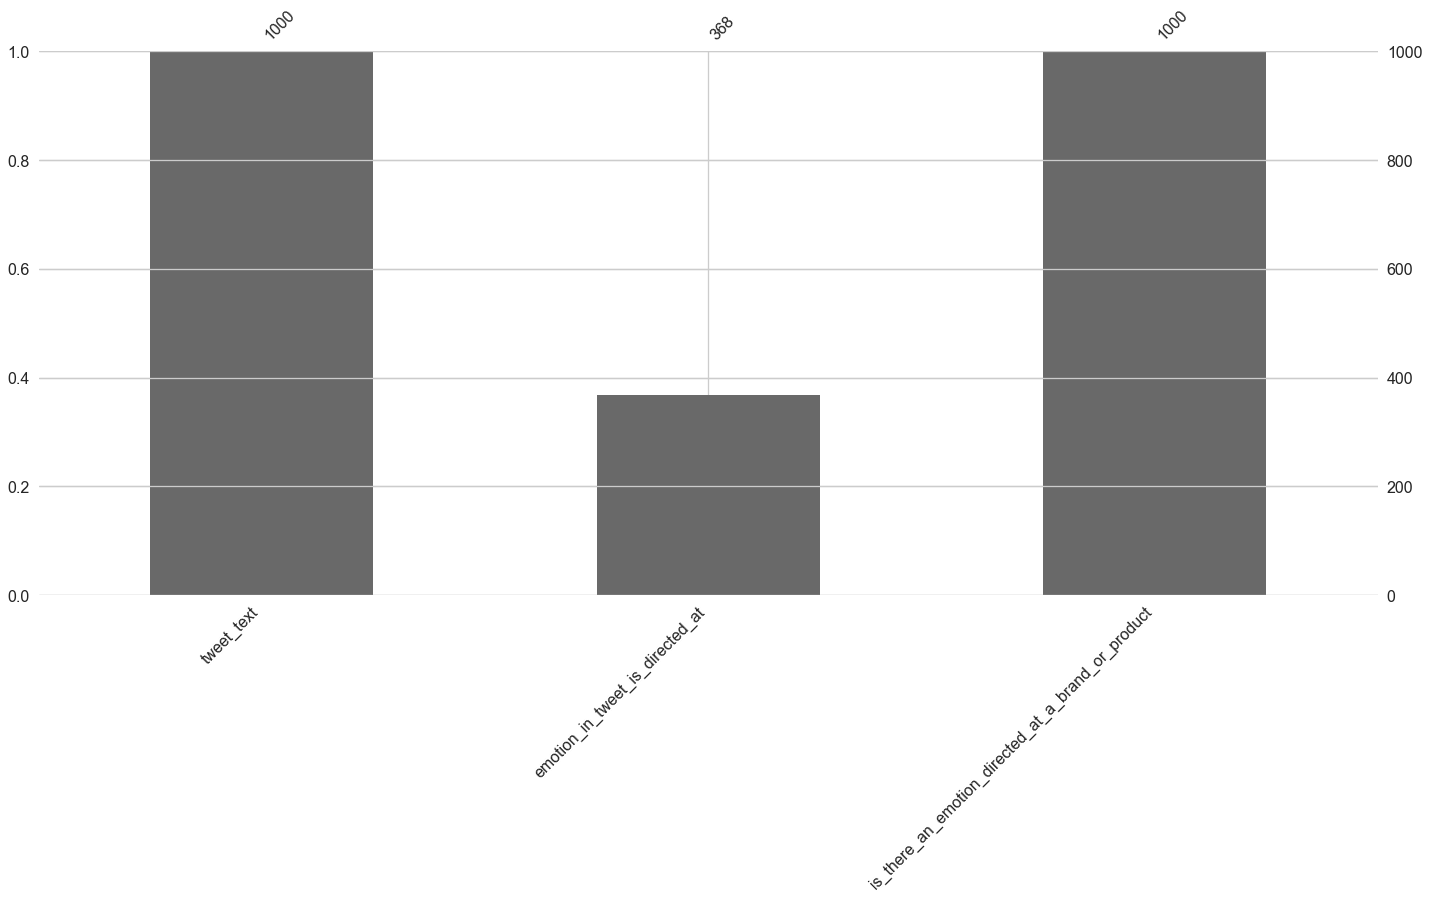

In [6]:
msno.bar(df.sample(1000))

In [8]:
df = df.drop('emotion_in_tweet_is_directed_at', axis=1)

df.isnull().sum()

tweet_text                                            1
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

In [9]:
# df.emotion_in_tweet_is_directed_at.value_counts(dropna=False)

AttributeError: 'DataFrame' object has no attribute 'emotion_in_tweet_is_directed_at'

In [ ]:
# print(5801 / len(df))

In [10]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [ ]:
# df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != 'No emotion toward brand or product']
# df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

# df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

In [12]:
df = df.dropna()

In [13]:
df.isnull().sum()

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

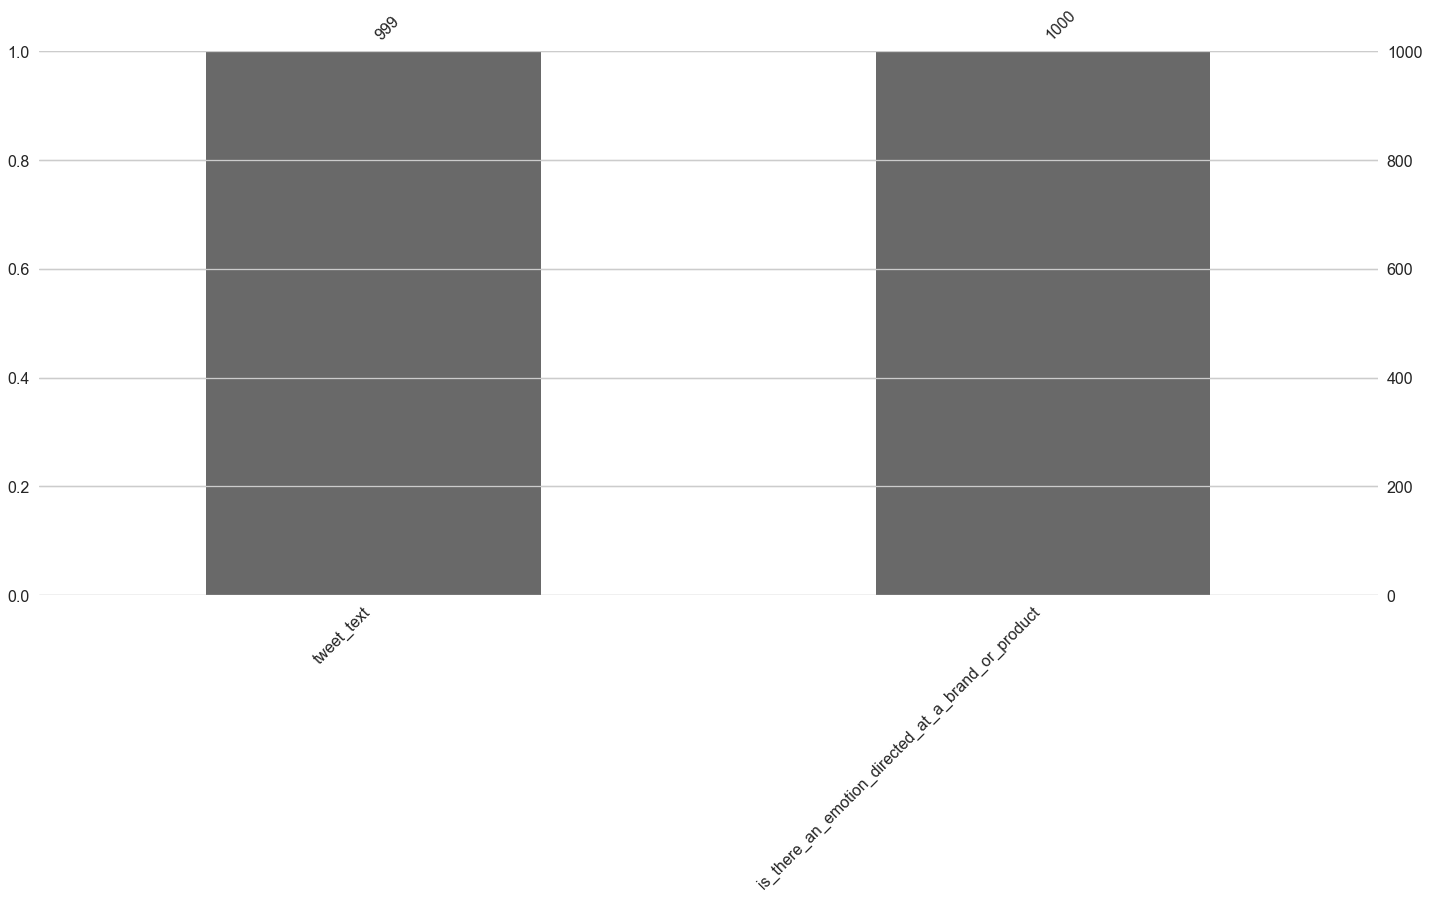

In [11]:
msno.bar(df.sample(1000))

# Preprocessing

## Renaming columns

In [14]:
df = df.rename(columns={"tweet_text": "text", "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"})
# "emotion_in_tweet_is_directed_at":"direction"
df

text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

                               sentiment  
0                       Negative emotion  
1                       Positive emotion  
2                       Positive emotion  
3                       Negative emotion  
4                       Positive emotion  
...                                  ...  
9088                    Positive emotion  
9089  No emotion toward brand or product  
9090  No emotion toward brand or product  
9091  No emotion toward brand or product  
9092  No emotion toward brand or product  

[9092 rows x 2 columns]

In [15]:
df.sentiment.value_counts(dropna=False)

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [16]:
# df.direction.value_counts(dropna=False)

## Mapping sentiment to 0 for negative, 1 for neutral, 2 for positive

In [17]:
df.sentiment = df.sentiment.map({'Positive emotion': 2, 'Negative emotion': 0, 'No emotion toward brand or product': 1, "I can't tell":1})

In [18]:
df.sentiment.value_counts(dropna=False)

1    5544
2    2978
0     570
Name: sentiment, dtype: int64

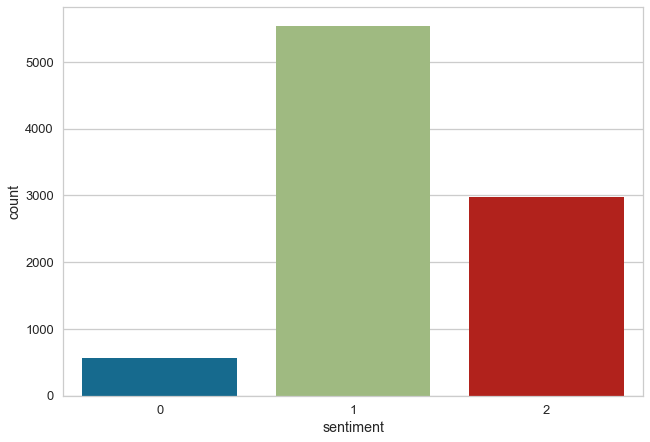

In [19]:
sns.countplot(df.sentiment)

In [ ]:
# df.direction.value_counts(dropna=False)

## Mapping direction of the tweet to 0 for apple and its products/services, 1 for google, 2 for unknown

In [ ]:
# df.direction = df.direction.map({'iPad':0, 'Apple':0,'iPad or iPhone App':0,'iPhone':0,'Other Apple product or service':0,'Google':1,'Other Google product or service':1,'Android App':1,'Android':1})

In [ ]:
# df.direction.value_counts(dropna=False)

In [ ]:
# sns.countplot(df.direction)

In [ ]:
# #Wherein 1 in sentiment is not having a strong emotion/can't tell, and 2 in direction is a NaN that's been filled 
# neutrals = [1,2]
# df[(df[['sentiment','direction']].values == neutrals).all(axis=1)]

In [ ]:
# len(df)

In [ ]:
# df.sentiment.value_counts(dropna=False)

In [ ]:
# df.direction.value_counts(dropna=False)

In [ ]:
# df.query('@neutrals[0] != sentiment and @neutrals[1] == direction').shape[0]

## Shows that the NaNs of direction were entered as a neutral sentiment

In [ ]:
# 5801 - 357

# General text preprocessing function

In [20]:
def preprocess(text):
    text = text.str.replace("(<br/>)", "")
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('(&amp)', '')
    text = text.str.replace('(&gt)', '')
    text = text.str.replace('(&lt)', '')
    text = text.str.replace('(\xa0)', ' ')  
    text = text.str.replace(',','')
    text = text.str.replace('{', '')
    text = text.str.replace('}', '')
    text = text.str.replace('.', '')
    text = text.str.replace(':', '')
    text = text.str.replace('-', '')
    return text

clean_df = df 
clean_df['text'] = preprocess(clean_df['text'])

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

# Creating new features
Creating features out of the length of a tweet, words in a tweet, and amounts of hashtags, capital words, and exclamation/question marks

In [21]:
def tweet_special_count(string, character):
    '''docstring'''
    w = string.split()
    
    char = [word for word in w if word.startswith(character)]
    
    return len(char)

In [22]:
clean_df['tweet_len'] = clean_df['text'].astype(str).apply(len)
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df["mean_word_len"] = clean_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_df['count_unique_word']=clean_df["text"].apply(lambda x: len(set(str(x).split())))
clean_df['word_unique_percent']=clean_df['count_unique_word']*100/clean_df['tweet_words']
clean_df.head()



text  sentiment  tweet_len  \
0  @wesley83 I have a 3G iPhone After 3 hrs tweet...          0        122   
1  @jessedee Know about @fludapp ? Awesome iPad/i...          2        137   
2  @swonderlin Can not wait for #iPad 2 also They...          2         77   
3  @sxsw I hope this year's festival isn't as cra...          0         81   
4  @sxtxstate great stuff on Fri #SXSW Marissa Ma...          2        125   

   tweet_words  hash_cnt  mention_cnt  capital_words  excl_q_marks  \
0           23         2            1              1             1   
1           22         1            2              1             1   
2           15         2            1              1             0   
3           15         1            1              0             0   
4           17         1            1              1             0   

   mean_word_len  count_unique_word  word_unique_percent  
0       4.304348                 21            91.304348  
1       5.272727                 22           100.000000  
2       4.200000                 15           100.000000  
3       4.466667                 12            80.000000  
4       6.411765                 17           100.000000

In [23]:
clean_df.columns

Index(['text', 'sentiment', 'tweet_len', 'tweet_words', 'hash_cnt',
       'mention_cnt', 'capital_words', 'excl_q_marks', 'mean_word_len',
       'count_unique_word', 'word_unique_percent'],
      dtype='object')

# Summary stats and visuals

## Top tokens - items and products with named entity recognition

In [24]:
from collections import Counter
tokens = nlp(''.join(str(df.text.tolist())))
items = [x.text for x in tokens.ents]
Counter(items).most_common(20)

[('Apple', 1122),
 ('iPhone', 843),
 ('Google', 775),
 ('SXSW', 750),
 ('Austin', 642),
 ('2', 490),
 ('today', 301),
 ('#sxsw #', 266),
 ('Today', 235),
 ('#sxsw', 234),
 ('Android', 232),
 ('#SXSW #', 232),
 ('sxsw', 152),
 ('Launch Major New Social Network', 152),
 ('Circles', 142),
 ('RT @mention', 138),
 ('SxSW', 107),
 ('iPad2', 95),
 ('RT @mention Google', 94),
 ("'RT @mention", 94)]

### Most Common Tokens W/Entities

In [25]:
item_cnt = Counter(items).most_common(20)
df_items = pd.DataFrame(item_cnt, columns =['text', 'count'])


fig = px.bar(df_items, y="text", x="count", orientation='h',title="Most Common Tokens W/ Entities Mentioned")
fig.show()

### Most Common Products

In [26]:
products = []
for ent in tokens.ents:
    if ent.label_ == 'PRODUCT':
        products.append(ent.text)
        
prdct_cnt = Counter(products).most_common(20)
df_prod = pd.DataFrame(prdct_cnt, columns =['text', 'count'])

fig = px.bar(df_prod, y="text", x="count", orientation='h',title="Most Common Products Mentioned")
fig.show()

## Analysis of numerical features- TBD: Writeup
### Distributions

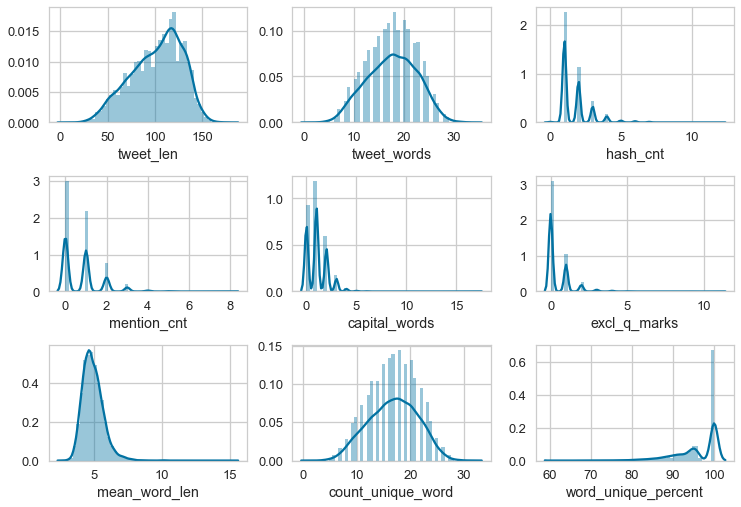

In [27]:
fig, axs = plt.subplots(ncols=3, nrows=3)
sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][2])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(clean_df['mean_word_len'], ax=axs[2][0])
sns.distplot(clean_df['count_unique_word'], ax=axs[2][1])
sns.distplot(clean_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

### Correlation matrix - looks like not much correlation/colinearity

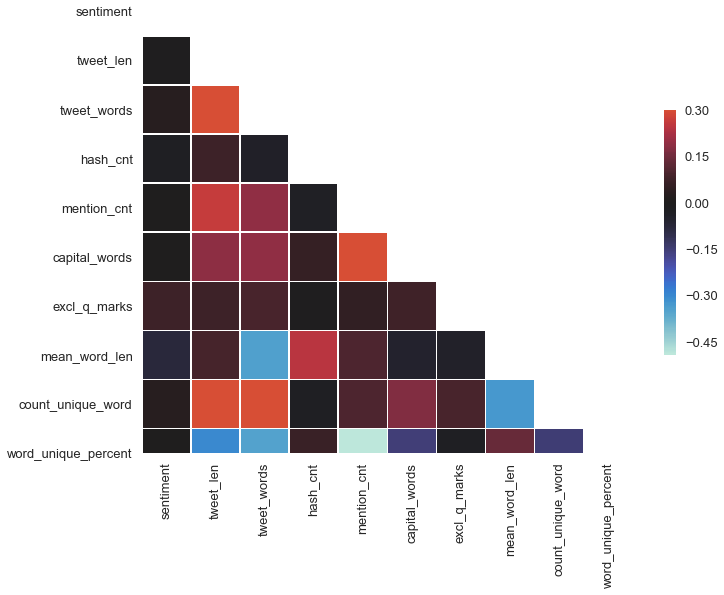

In [28]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Pairplot

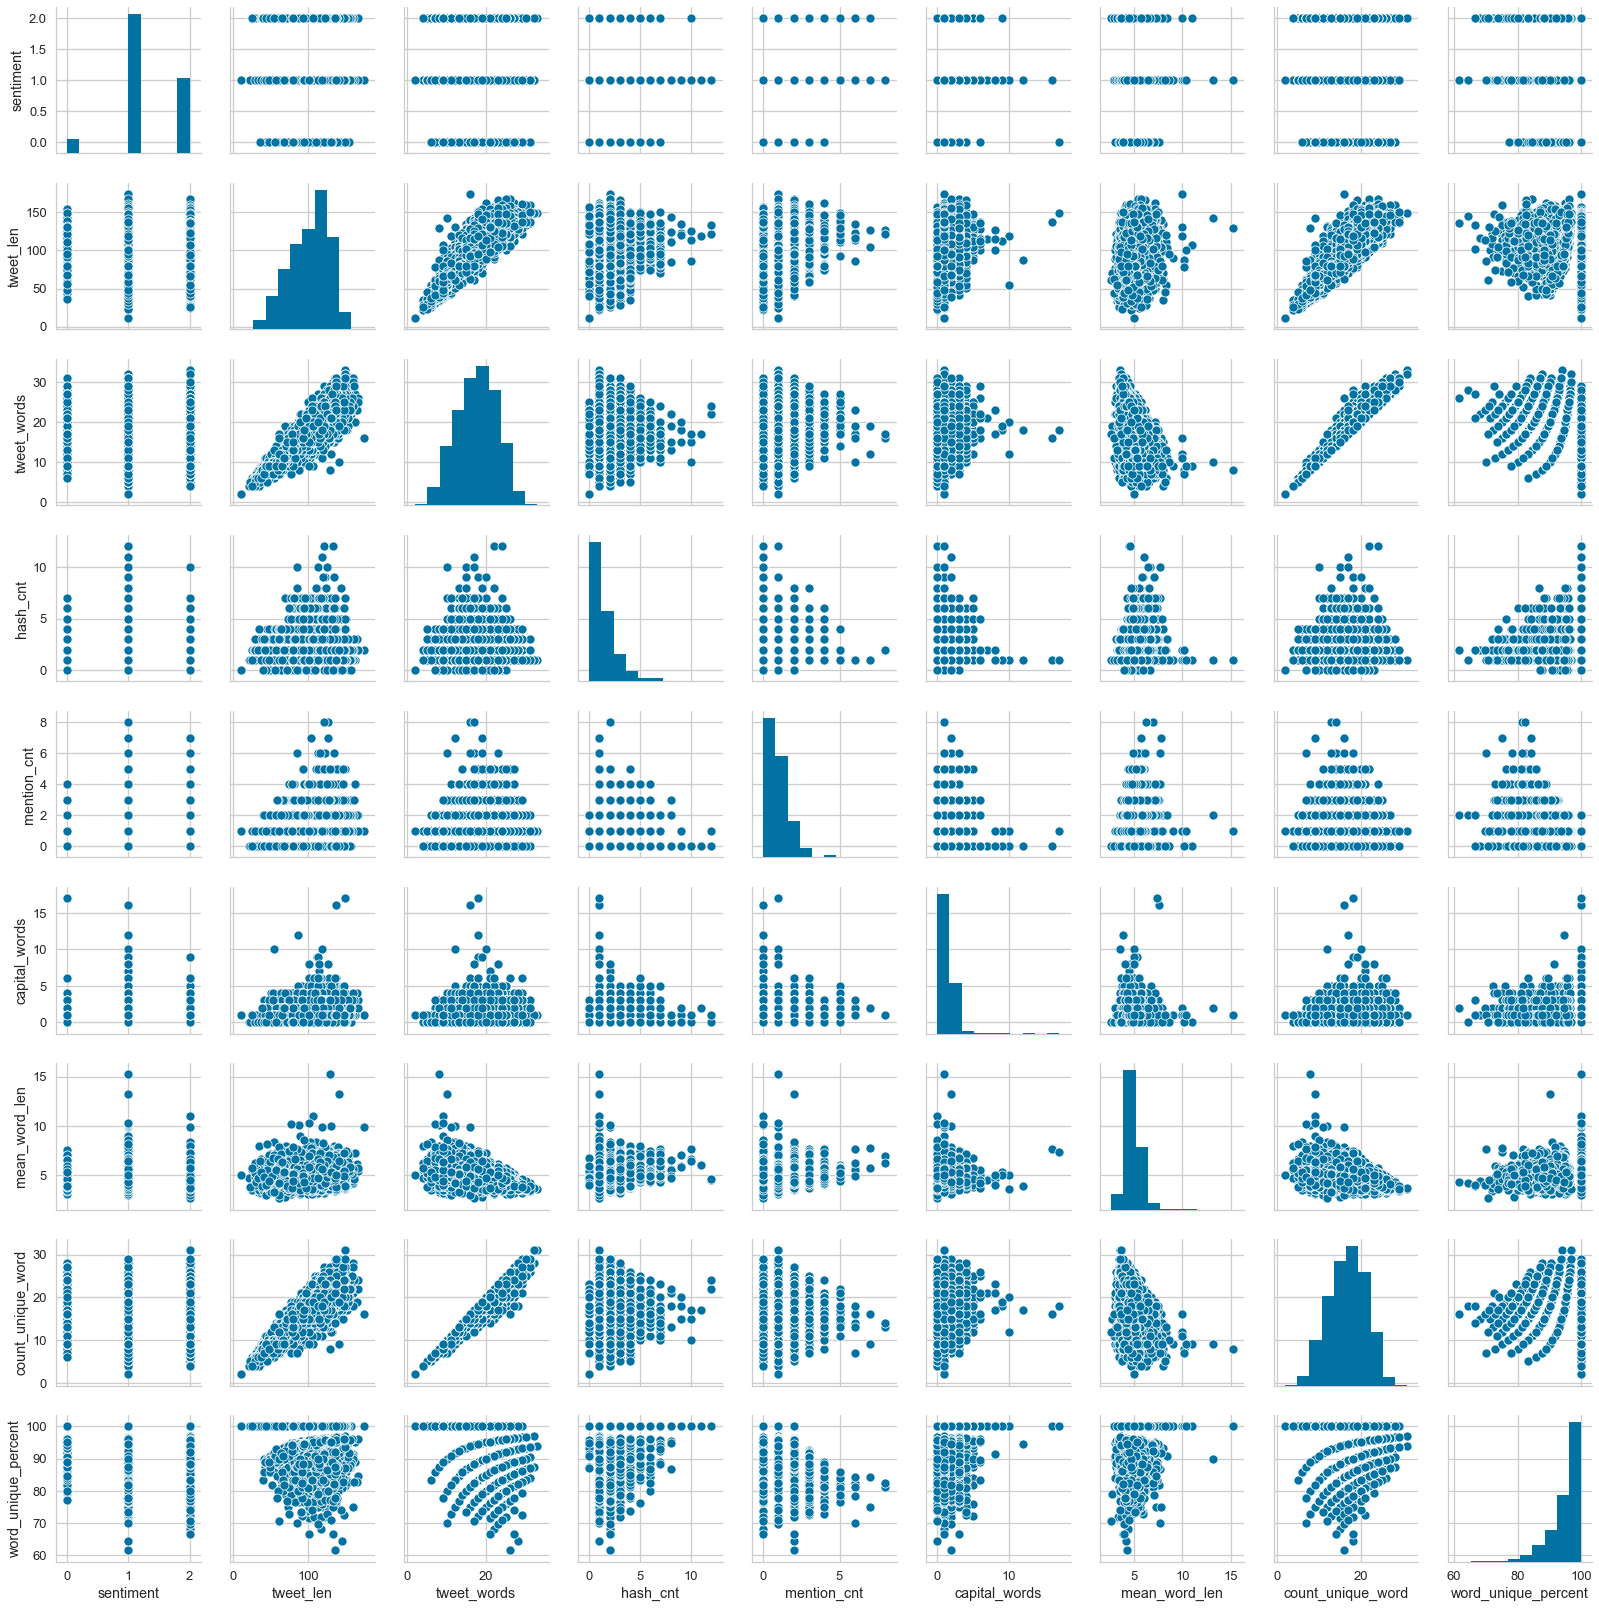

In [29]:
sns.pairplot(clean_df[[ 'sentiment', 'tweet_len','tweet_words',
       'hash_cnt', 'mention_cnt', 'capital_words','mean_word_len', 'count_unique_word', 'word_unique_percent']])
# 'direction'

#### Dropping tweet_len due to high correlation with tweet_words

In [30]:
clean_df = clean_df.drop('tweet_len',axis=1)

clean_df.head()

text  sentiment  tweet_words  \
0  @wesley83 I have a 3G iPhone After 3 hrs tweet...          0           23   
1  @jessedee Know about @fludapp ? Awesome iPad/i...          2           22   
2  @swonderlin Can not wait for #iPad 2 also They...          2           15   
3  @sxsw I hope this year's festival isn't as cra...          0           15   
4  @sxtxstate great stuff on Fri #SXSW Marissa Ma...          2           17   

   hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
0         2            1              1             1       4.304348   
1         1            2              1             1       5.272727   
2         2            1              1             0       4.200000   
3         1            1              0             0       4.466667   
4         1            1              1             0       6.411765   

   count_unique_word  word_unique_percent  
0                 21            91.304348  
1                 22           100.000000  
2                 15           100.000000  
3                 12            80.000000  
4                 17           100.000000

# Further preprocessing - tokenizing and lemmatizing, stopword removal

In [31]:
clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

In [32]:
from wordcloud import WordCloud

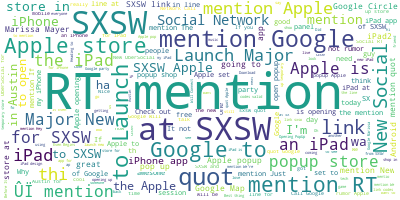

In [33]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

In [34]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def stem_sentences(sentence):
    tokens = sentence.split()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemma_tokens)

clean_df['text'] = clean_df['text'].apply(stem_sentences)

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hr tweeti...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't a cras...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customer complained their ...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

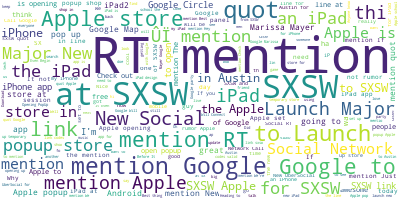

In [35]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

In [36]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelburak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
clean_df['text'] = clean_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))

clean_df['text']

0       @wesley83 I 3G iPhone After 3 hr tweeting #RIS...
1       @jessedee Know @fludapp ? Awesome iPad/iPhone ...
2       @swonderlin Can wait #iPad 2 also They sale #SXSW
3       @sxsw I hope year's festival crashy year's iPh...
4       @sxtxstate great stuff Fri #SXSW Marissa Mayer...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt regularly s...
9090    Google's Zeiger physician never reported poten...
9091    Some Verizon iPhone customer complained time f...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

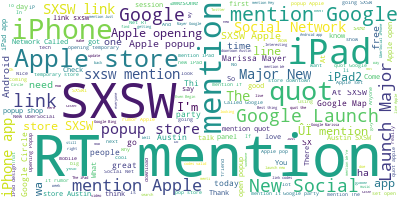

In [38]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

# Features after cleaning and analysis

In [39]:
clean_df['tweet_len'] = clean_df['text'].astype(str).apply(len)
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df["mean_word_len"] = clean_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_df['count_unique_word']=clean_df["text"].apply(lambda x: len(set(str(x).split())))
clean_df['word_unique_percent']=clean_df['count_unique_word']*100/clean_df['tweet_words']
clean_df.head()

text  sentiment  tweet_words  \
0  @wesley83 I 3G iPhone After 3 hr tweeting #RIS...          0           17   
1  @jessedee Know @fludapp ? Awesome iPad/iPhone ...          2           16   
2  @swonderlin Can wait #iPad 2 also They sale #SXSW          2            9   
3  @sxsw I hope year's festival crashy year's iPh...          0           10   
4  @sxtxstate great stuff Fri #SXSW Marissa Mayer...          2           16   

   hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
0         2            1              1             1       4.882353   
1         1            2              1             1       5.812500   
2         2            1              1             0       4.555556   
3         1            1              0             0       5.000000   
4         1            1              1             0       6.687500   

   count_unique_word  word_unique_percent  tweet_len  
0                 16            94.117647         99  
1                 16           100.000000        108  
2                  9           100.000000         49  
3                  9            90.000000         59  
4                 16           100.000000        122

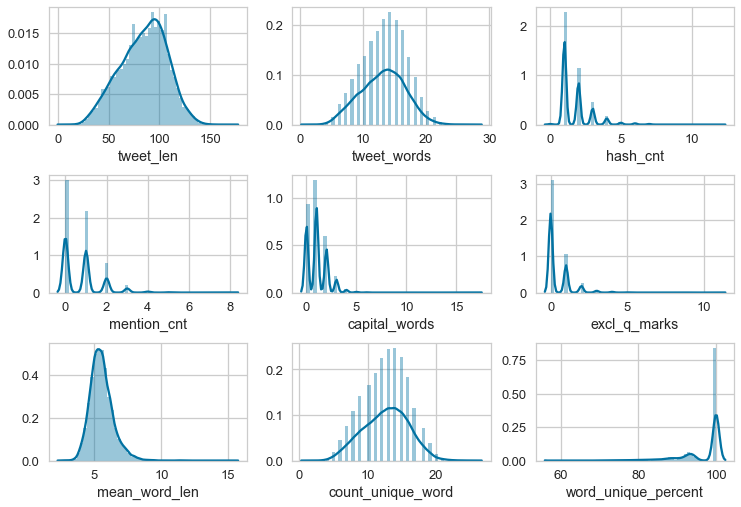

In [40]:
fig, axs = plt.subplots(ncols=3, nrows=3)
sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][2])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(clean_df['mean_word_len'], ax=axs[2][0])
sns.distplot(clean_df['count_unique_word'], ax=axs[2][1])
sns.distplot(clean_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

In [41]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
clean_df['tokens'] = clean_df['text'].apply(tt.tokenize)

# Visuals, continued

## t-SNE of k-means clusters, overall document, text vs. classes

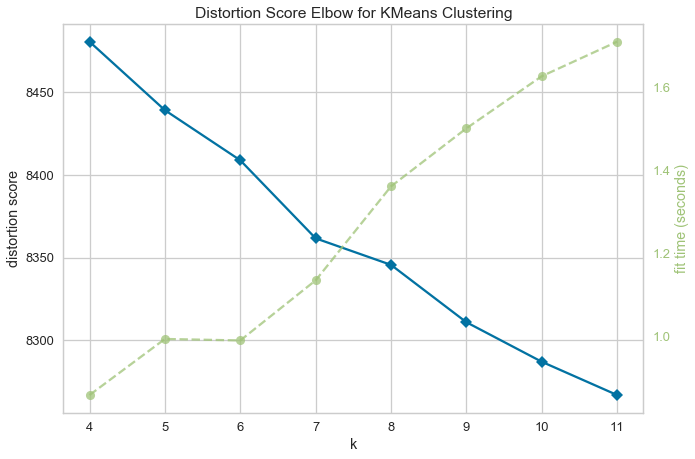

In [42]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(clean_df['text'])

tf_words = tfidf.get_feature_names()

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)
visualizer.show() 

### t-SNE of K-means

In [43]:
from yellowbrick.text import TSNEVisualizer
X = tfidf.fit_transform(clean_df['text'])


In [45]:
clusters = KMeans(n_clusters=7)
clusters.fit(X)


KMeans(n_clusters=7)

W0628 12:14:15.458683 4673482176 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0628 12:14:15.493608 4673482176 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0628 12:14:15.528101 4673482176 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0628 1

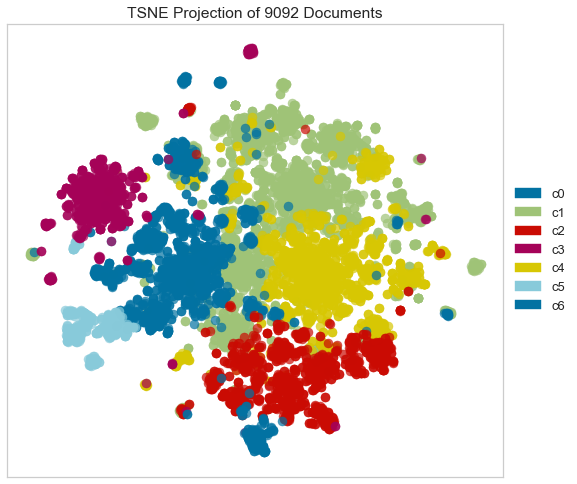

0 : google, mention, sxsw, link, rt, circles, mayer, party, mobile, marissa
1 : mention, iphone, sxsw, link, app, rt, android, free, apple, new
2 : apple, store, popup, sxsw, link, mention, austin, ipad2, line, open
3 : quot, mention, sxsw, google, rt, ipad, apple, heard, link, go
4 : ipad, mention, sxsw, link, rt, win, the, new, app, design
5 : network, social, circles, called, launch, major, new, today, possibly, google
6 : opening, downtown, temporary, austin, launch, store, apple, rumor, mention, it


In [46]:
tsne = TSNEVisualizer(size=(800, 600))
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])

tsne.show()
common_words = clusters.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(tf_words[word] for word in centroid))
    


### TSNE of tweet text

W0628 12:14:50.304101 4673482176 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


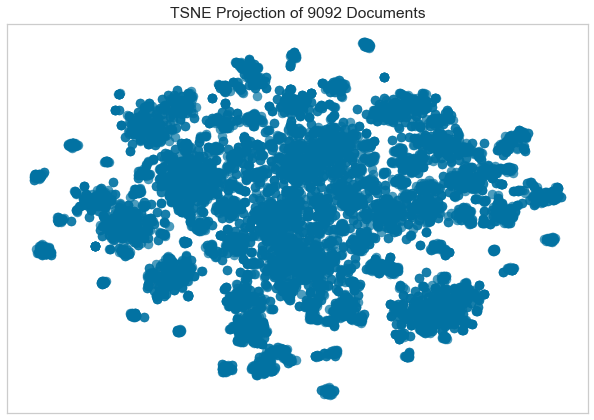

In [47]:
tsne = TSNEVisualizer()
tsne.fit(X)
tsne.show()

### TSNE of tweet text and sentiment

W0628 12:15:28.119249 4673482176 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0628 12:15:28.158768 4673482176 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0628 12:15:28.232841 4673482176 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


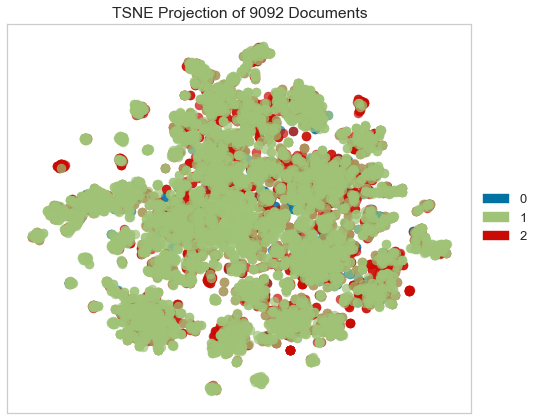

In [48]:
y = clean_df['sentiment']
tsne = TSNEVisualizer()
tsne.fit(X,y)
tsne.show()

### Word modeling t-SNE

In [49]:
from gensim.models import word2vec
from sklearn.manifold import TSNE

In [50]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(clean_df)        
corpus[0:2]

[['@wesley83',
  'I',
  '3G',
  'iPhone',
  'After',
  '3',
  'hr',
  'tweeting',
  '#RISE_Austin',
  'wa',
  'dead!',
  'I',
  'need',
  'upgrade',
  'Plugin',
  'station',
  '#SXSW'],
 ['@jessedee',
  'Know',
  '@fludapp',
  '?',
  'Awesome',
  'iPad/iPhone',
  'app',
  'likely',
  'appreciate',
  'design',
  'Also',
  "they're",
  'giving',
  'free',
  'Ts',
  '#SXSW']]

In [51]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['Google']

array([ 0.00858109, -0.08414809, -0.11781894, -0.07820068,  0.1951287 ,
       -0.04453229,  0.02134428, -0.14275841, -0.29197672, -0.13401319,
        0.36747128, -0.04614725,  0.3407248 , -0.2691942 , -0.51443154,
       -0.00325545, -0.06125285,  0.20333186, -0.21753415,  0.09878294,
        0.28492612, -0.2430761 , -0.17236723, -0.35006478,  0.02529749,
        0.07662468,  0.14681816,  0.298812  , -0.10469586,  0.11430918,
        0.29832914, -0.25156826,  0.2077181 ,  0.00088   , -0.20335735,
       -0.39250615, -0.01336514,  0.00474671, -0.0117478 , -0.18544036,
       -0.11300078, -0.21984279,  0.11370312, -0.10150031,  0.05875608,
        0.1287952 ,  0.21001351,  0.19088836,  0.09369377, -0.09174144,
       -0.1968645 ,  0.17342195, -0.03272812,  0.27743703,  0.18709628,
        0.00662895,  0.22283457,  0.553955  ,  0.14111888, -0.13097015,
        0.29328087, -0.10042398, -0.18917038,  0.18938896,  0.07904153,
       -0.16794237, -0.10527892, -0.20407698,  0.09840069,  0.04

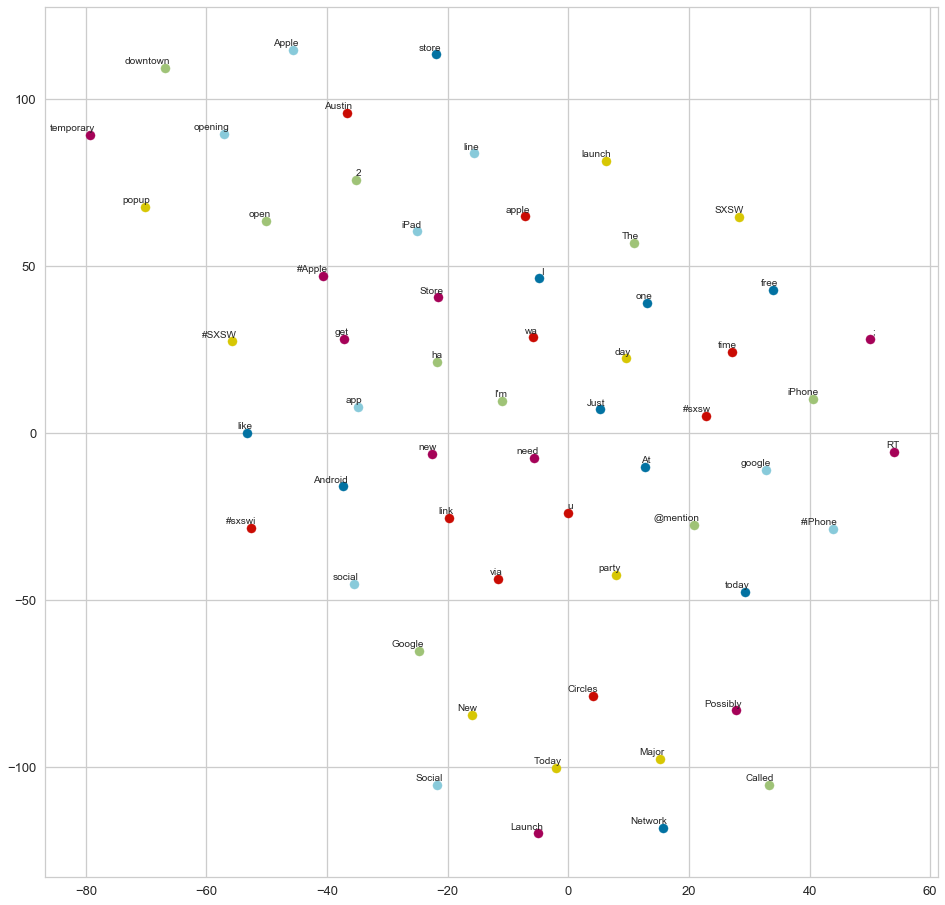

In [52]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model)

# Word2Vec Similarities and plots

In [53]:
google_similar = model.most_similar('Google')

google_similar

[('Circles', 0.9891326427459717),
 ('New', 0.9868427515029907),
 ('Launch', 0.983757734298706),
 ('Social', 0.9825894236564636),
 ('Today', 0.9821633100509644),
 ('Possibly', 0.9809234142303467),
 ('Called', 0.9787739515304565),
 ('Network', 0.9781469106674194),
 ('Major', 0.9772951602935791),
 ('social', 0.954140305519104)]

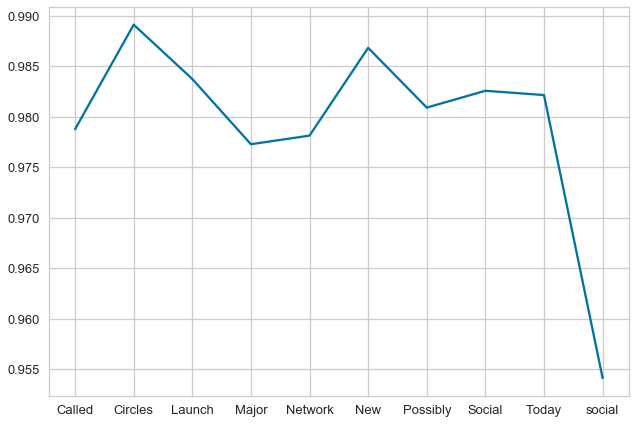

In [54]:
sns.lineplot(*zip(*google_similar))

In [55]:
apple_similar = model.most_similar('Apple')

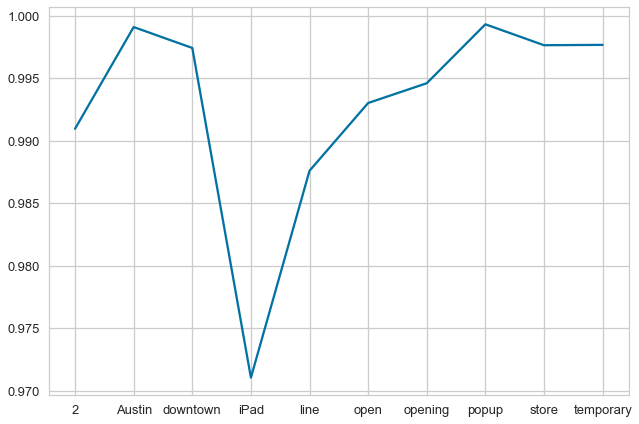

In [56]:
sns.lineplot(*zip(*apple_similar))

# Bigrams and N-grams

In [57]:
from nltk import bigrams

In [58]:
clean_df['tokens']

0       [@wesley83, I, 3G, iPhone, After, 3, hr, tweet...
1       [@jessedee, Know, @fludapp, ?, Awesome, iPad, ...
2       [@swonderlin, Can, wait, #iPad, 2, also, They,...
3       [@sxsw, I, hope, year's, festival, crashy, yea...
4       [@sxtxstate, great, stuff, Fri, #SXSW, Marissa...
                              ...                        
9088                      [Ipad, everywhere, #SXSW, link]
9089    [Wave, buzz, RT, @mention, We, interrupt, regu...
9090    [Google's, Zeiger, physician, never, reported,...
9091    [Some, Verizon, iPhone, customer, complained, ...
9092    [, Ï, ¡, , Ïà, , ü_, , , Ê, , , Î, , ...
Name: tokens, Length: 9092, dtype: object

In [59]:
#create bigrams
bigram_list = [list(bigrams(tweet)) for tweet in clean_df['tokens']]

bigram_list[:11]

[[('@wesley83', 'I'),
  ('I', '3G'),
  ('3G', 'iPhone'),
  ('iPhone', 'After'),
  ('After', '3'),
  ('3', 'hr'),
  ('hr', 'tweeting'),
  ('tweeting', '#RISE_Austin'),
  ('#RISE_Austin', 'wa'),
  ('wa', 'dead'),
  ('dead', '!'),
  ('!', 'I'),
  ('I', 'need'),
  ('need', 'upgrade'),
  ('upgrade', 'Plugin'),
  ('Plugin', 'station'),
  ('station', '#SXSW')],
 [('@jessedee', 'Know'),
  ('Know', '@fludapp'),
  ('@fludapp', '?'),
  ('?', 'Awesome'),
  ('Awesome', 'iPad'),
  ('iPad', '/'),
  ('/', 'iPhone'),
  ('iPhone', 'app'),
  ('app', 'likely'),
  ('likely', 'appreciate'),
  ('appreciate', 'design'),
  ('design', 'Also'),
  ('Also', "they're"),
  ("they're", 'giving'),
  ('giving', 'free'),
  ('free', 'Ts'),
  ('Ts', '#SXSW')],
 [('@swonderlin', 'Can'),
  ('Can', 'wait'),
  ('wait', '#iPad'),
  ('#iPad', '2'),
  ('2', 'also'),
  ('also', 'They'),
  ('They', 'sale'),
  ('sale', '#SXSW')],
 [('@sxsw', 'I'),
  ('I', 'hope'),
  ('hope', "year's"),
  ("year's", 'festival'),
  ('festival', 'cras

In [60]:
flat_bigrams = [item for sublist in bigram_list for item in sublist]

flat_bigrams[:11]

[('@wesley83', 'I'),
 ('I', '3G'),
 ('3G', 'iPhone'),
 ('iPhone', 'After'),
 ('After', '3'),
 ('3', 'hr'),
 ('hr', 'tweeting'),
 ('tweeting', '#RISE_Austin'),
 ('#RISE_Austin', 'wa'),
 ('wa', 'dead'),
 ('dead', '!')]

## Top 20 bigrams

In [61]:
import itertools
from collections import Counter

bigram_count = Counter(flat_bigrams)

bigram_count.most_common(20)

[(('RT', '@mention'), 2855),
 (('iPad', '2'), 986),
 (('@mention', '@mention'), 566),
 (('link', '#sxsw'), 513),
 (('#SXSW', 'link'), 453),
 (('@mention', 'Google'), 361),
 (('via', '@mention'), 346),
 (('Social', 'Network'), 308),
 (('New', 'Social'), 292),
 (('@mention', '#sxsw'), 278),
 (('Network', 'Called'), 277),
 (('Major', 'New'), 267),
 (('Launch', 'Major'), 266),
 (('!', 'link'), 258),
 (('Called', 'Circles'), 255),
 (('popup', 'store'), 254),
 (('Google', 'Launch'), 253),
 (('#sxsw', 'link'), 253),
 (('link', '#SXSW'), 243),
 (('Apple', 'Store'), 236)]

In [62]:
bigram_df = pd.DataFrame(bigram_count.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

bigram  count
0         (RT, @mention)   2855
1              (iPad, 2)    986
2   (@mention, @mention)    566
3          (link, #sxsw)    513
4          (#SXSW, link)    453
5     (@mention, Google)    361
6        (via, @mention)    346
7      (Social, Network)    308
8          (New, Social)    292
9      (@mention, #sxsw)    278
10     (Network, Called)    277
11          (Major, New)    267
12       (Launch, Major)    266
13             (!, link)    258
14     (Called, Circles)    255
15        (popup, store)    254
16      (Google, Launch)    253
17         (#sxsw, link)    253
18         (link, #SXSW)    243
19        (Apple, Store)    236

## Plot of top 20 bigrams

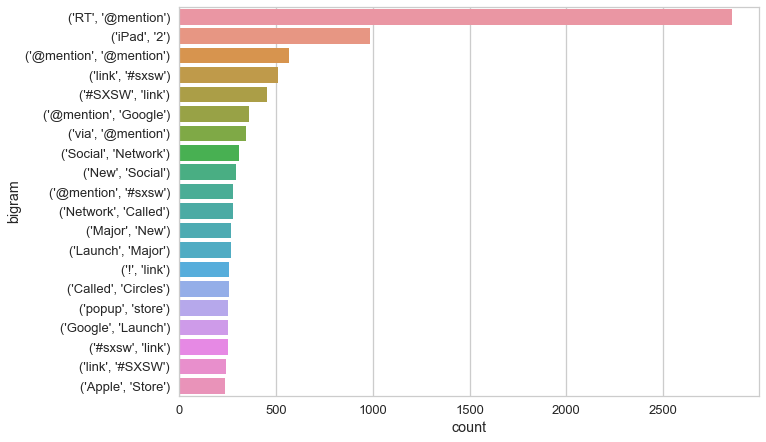

In [63]:
sns.barplot(data=bigram_df, x="count", y="bigram")

## Network plot of bigrams

In [64]:
import networkx as nx


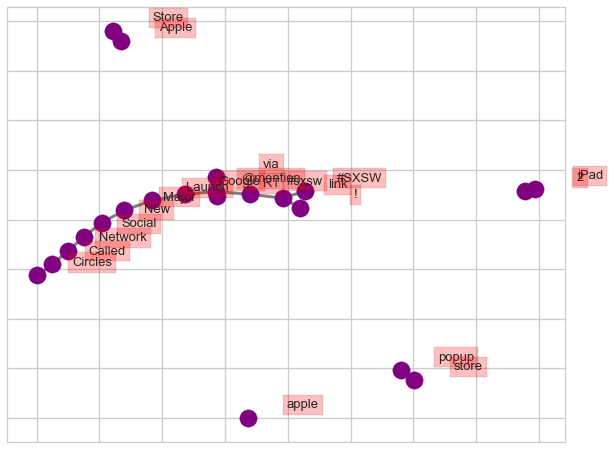

In [65]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("apple", weight=100)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=12,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.175, value[1]+.050
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

# TBD: LDA visualization

# Modeling

## TBD: Multiple classifiers, tuning, better display of metrics, feature impact/analysis of models

In [66]:
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.ensemble import RandomForestClassifier

## Making a scorer for grid searching out of cohen's kappa and a function for selective f-scores

In [67]:
from sklearn.metrics import cohen_kappa_score, make_scorer
kappa_scorer = make_scorer(cohen_kappa_score)

## DataFrameMapper with Tf-idf Vectorization

In [68]:
mapper = DataFrameMapper([
     ('text', TfidfVectorizer()),
#      ('direction', None),
     ('tweet_words', None),
    ('hash_cnt', None),
    ('mention_cnt', None),
    ('capital_words', None),
    ('excl_q_marks', None),
    ('mean_word_len',None),
    ('count_unique_word',None),
    ('word_unique_percent',None)
 ])

In [69]:
X = mapper.fit_transform(clean_df)

In [70]:
X

array([[  0.        ,   0.        ,   0.        , ...,   4.88235294,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.8125    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,   4.55555556,
          9.        , 100.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   7.        ,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.5625    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,  10.33333333,
          9.        , 100.        ]])

In [71]:
# clean_df.direction.value_counts(dropna=False)

## Train test splits

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
y = clean_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

# TBD: Comparison of scaler effects - both decreased performance greatly

## Minmax Scaling

In [73]:
# from sklearn import preprocessing
# mm_scaler = preprocessing.MinMaxScaler()
# X_train_mm = mm_scaler.fit_transform(X_train)
# X_test_mm = mm_scaler.transform(X_test)

## Standard scaling

In [74]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_sts = scaler.fit_transform(X_train)
# X_test_sts = scaler.transform(X_test)

## PCA train_test split- TBD if/how using

In [75]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# X_pca = X
# pca.fit(X_pca)

# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.33, random_state=42,stratify=y)

## Comparing class balance 

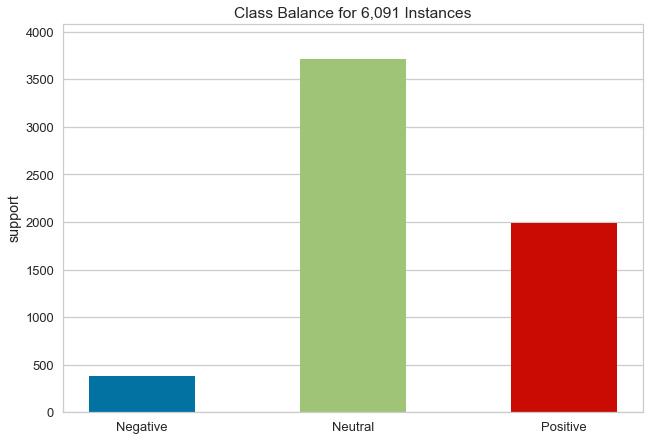

In [77]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative","Neutral", "Positive"])

visualizer.fit(y_train)
visualizer.show()

# SVC Base Model for Comparison

In [79]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       188
           1       0.62      1.00      0.77      1830
           2       0.95      0.05      0.10       983

    accuracy                           0.63      3001
   macro avg       0.52      0.35      0.29      3001
weighted avg       0.69      0.63      0.50      3001



In [80]:
from sklearn.metrics import fbeta_score

def fscores(y_test=y_test, y_pred=y_pred):
    f05 = fbeta_score(y_test, y_pred, average=None, beta=0.5, labels=[0,1,2])
    f2 = fbeta_score(y_test, y_pred, average=None, beta=2.0, labels=[0,1,2])
    for idx,c in enumerate(f05):
        print (f'F0.5 of {idx} class is {f05[idx]}')
        print (f'F2 of {idx} class is {f2[idx]}')
        print ('-----------')


In [81]:
svc_cohen = cohen_kappa_score(y_test, y_pred)

print(svc_cohen)

0.057356875184213174


In [82]:
fscores()

F0.5 of 0 class is 0.0
F2 of 0 class is 0.0
-----------
F0.5 of 1 class is 0.6717624577392327
F2 of 1 class is 0.8904910366328916
-----------
F0.5 of 2 class is 0.22295623451692817
F2 of 2 class is 0.06768613687641013
-----------


## Balanced SVC

In [83]:
clf = LinearSVC(class_weight="balanced", random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       188
           1       1.00      0.00      0.00      1830
           2       0.33      1.00      0.49       983

    accuracy                           0.33      3001
   macro avg       0.44      0.33      0.17      3001
weighted avg       0.72      0.33      0.16      3001



In [84]:
svc_bal_cohen = cohen_kappa_score(y_test, y_pred)

print(svc_cohen)

0.057356875184213174


In [85]:
fscores()

F0.5 of 0 class is 0.0
F2 of 0 class is 0.0
-----------
F0.5 of 1 class is 0.6717624577392327
F2 of 1 class is 0.8904910366328916
-----------
F0.5 of 2 class is 0.22295623451692817
F2 of 2 class is 0.06768613687641013
-----------


# Tuning SVC

In [88]:
from sklearn.model_selection import GridSearchCV

In [89]:
param_grid = {'C': [0.1,1, 10, 100]}

In [90]:
grid = GridSearchCV(LinearSVC(class_weight="balanced", random_state=0),param_grid,refit=True,verbose=2, scoring=kappa_scorer, n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   19.7s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.1s finished


GridSearchCV(estimator=LinearSVC(class_weight='balanced', random_state=0),
             n_jobs=-1, param_grid={'C': [0.1, 1, 10, 100]},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [91]:
print(grid.best_estimator_)

LinearSVC(C=0.1, class_weight='balanced', random_state=0)


In [92]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.28      0.30      0.29       188
           1       0.69      0.87      0.77      1830
           2       0.65      0.34      0.45       983

    accuracy                           0.66      3001
   macro avg       0.54      0.50      0.50      3001
weighted avg       0.66      0.66      0.64      3001



In [93]:
grid_bal_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_bal_cohen)

0.2842996968271393


# Undersampling techniques

In [94]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [95]:
from imblearn.under_sampling import NearMiss # doctest: +NORMALIZE_WHITESPACE
print('Original dataset shape %s' % Counter(y))
nm = NearMiss()
X_res, y_res = nm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 5544, 2: 2978, 0: 570})
Resampled dataset shape Counter({0: 382, 1: 382, 2: 382})


In [96]:
model = LinearSVC(class_weight="balanced", random_state=0)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.06      0.18      0.09       188
           1       0.68      0.49      0.57      1830
           2       0.41      0.45      0.43       983

    accuracy                           0.46      3001
   macro avg       0.38      0.37      0.36      3001
weighted avg       0.55      0.46      0.49      3001



In [97]:
bal_nm_cohen = cohen_kappa_score(y_test,y_pred)
print(bal_nm_cohen)

0.09662287859098029


## Grid search on undersampling

In [98]:
grid.fit(X_res,y_res)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    0.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.2s finished


GridSearchCV(estimator=LinearSVC(class_weight='balanced', random_state=0),
             n_jobs=-1, param_grid={'C': [0.1, 1, 10, 100]},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [99]:
print(grid.best_estimator_)

LinearSVC(C=0.1, class_weight='balanced', random_state=0)


In [100]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.06      1.00      0.12       188
           1       0.88      0.00      0.01      1830
           2       0.00      0.00      0.00       983

    accuracy                           0.06      3001
   macro avg       0.31      0.33      0.04      3001
weighted avg       0.54      0.06      0.01      3001



In [101]:
grid_nm_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_nm_cohen)

0.0009338357609386394


# Other undersampling techniques

In [102]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule()
X_resampled, y_resampled = ncr.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 382), (1, 2525), (2, 541)]


In [103]:
model = LinearSVC(class_weight="balanced", random_state=0)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       188
           1       0.61      1.00      0.76      1830
           2       0.90      0.02      0.04       983

    accuracy                           0.62      3001
   macro avg       0.51      0.34      0.27      3001
weighted avg       0.67      0.62      0.48      3001



In [104]:
bal_ncr_cohen = cohen_kappa_score(y_test, grid_predictions)
print(bal_ncr_cohen)

0.0009338357609386394


## Tuned SVC on NCR

In [105]:
grid.fit(X_resampled,y_resampled)
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    6.8s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    8.1s finished


              precision    recall  f1-score   support

           0       0.19      0.49      0.28       188
           1       0.79      0.48      0.60      1830
           2       0.46      0.67      0.55       983

    accuracy                           0.54      3001
   macro avg       0.48      0.55      0.47      3001
weighted avg       0.65      0.54      0.56      3001



In [106]:
tune_ncr_cohen = cohen_kappa_score(y_test, grid_predictions)

In [107]:
print(tune_ncr_cohen)

0.2493835691623113


# TBD: Conclusions - best model results and interpretation, business recommendations, future work

# Future work: Outlier detection approaches, multilabel classification